# **RBM**

In [45]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt

In [46]:
class RBM:
    def __init__(self, num_visible, num_hidden):
        self.num_visible = num_visible
        self.num_hidden = num_hidden
        self.W = np.random.randn(num_visible, num_hidden) * 0.1
        self.b = np.zeros(num_hidden)
        self.a = np.zeros(num_visible)

    def sigmoid(self, x):
        return 1.0 / (1.0 + np.exp(-x))

    def gibbs_sampling(self, v, k):
        for _ in range(k):
            h_prob = self.sigmoid(np.dot(v, self.W) + self.b)
            h_sample = np.random.binomial(1, h_prob)
            v_prob = self.sigmoid(np.dot(h_sample, self.W.T) + self.a)
            v = np.random.binomial(1, v_prob)
        return v, h_sample

    def compute_reconstruction_error(self, data):
      reconstructed_data = self.sigmoid(np.dot(self.sigmoid(np.dot(data, self.W) + self.b), self.W.T) + self.a)
      error = np.mean(np.sum(np.square(data - reconstructed_data), axis=1))
      return error

    def free_energy(self, v):
        vbias_term = np.dot(v, self.a)
        wx_b = np.dot(v, self.W) + self.b
        hidden_term = np.sum(np.log(1 + np.exp(wx_b)), axis=1)
        return -np.mean(vbias_term + hidden_term)

    def pseudo_likelihood(self, v):
        v_binary = (v > 0.5).astype(np.float32)
        i = np.random.randint(0, self.num_visible)
        v_flip = v_binary.copy()
        v_flip[:, i] = 1 - v_flip[:, i]
        energy_original = self.free_energy(v_binary)
        energy_flip = self.free_energy(v_flip)
        pseudo_likelihood = self.num_visible * np.log(self.sigmoid(energy_flip - energy_original))
        return np.mean(pseudo_likelihood)

    def train(self, data, learning_rate, k, epochs, batch_size):
        num_batches = len(data) // batch_size
        costs = []

        for epoch in range(epochs):
            np.random.shuffle(data)
            for batch_idx in range(num_batches):
                batch_data = data[batch_idx * batch_size : (batch_idx + 1) * batch_size]

                v_0 = batch_data
                h_0_prob = self.sigmoid(np.dot(v_0, self.W) + self.b)
                h_0 = np.random.binomial(1, h_0_prob)

                v_k, h_k = self.gibbs_sampling(v_0, k)

                h_k_prob = self.sigmoid(np.dot(v_k, self.W) + self.b)

                pos_associations = np.dot(v_0.T, h_0_prob)
                neg_associations = np.dot(v_k.T, h_k_prob)

                self.W += learning_rate * (pos_associations - neg_associations) / batch_size
                self.a += learning_rate * np.mean(v_0 - v_k, axis=0)
                self.b += learning_rate * np.mean(h_0_prob - h_k_prob, axis=0)

            cost = self.compute_reconstruction_error(data)
            costs.append(cost)
            print(f'Epoch: {epoch+1}, Reconstruction Error: {cost}')
        return costs

    def reconstruct(self, v):
        h = self.sigmoid(np.dot(v, self.W) + self.b)
        v_reconstructed = self.sigmoid(np.dot(h, self.W.T) + self.a)
        return v_reconstructed

    def plot_receptive_fields(self, shape):
        fig, axes = plt.subplots(int(np.sqrt(self.num_hidden)), int(np.sqrt(self.num_hidden)), figsize=(10, 10))
        fig.suptitle('Receptive Fields of Hidden Units')
        for i, ax in enumerate(axes.flat):
            if i < self.num_hidden:
                ax.imshow(self.W[:, i].reshape(shape), cmap='gray')
                ax.axis('off')
        plt.show()



# ***MNIST Dataset***

In [47]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

#normalization
x_train = x_train / 255.0
x_train = x_train.reshape(-1, 784)  #convert 28x28 image to a vector

x_test = x_test / 255.0
x_test = x_test.reshape(-1, 784)
x_test = (x_test > 0.5).astype(int)


num_visible = 784
num_hidden = 64
rbm = RBM(num_visible, num_hidden)

learning_rate = 0.1
k = 1
epochs = 20
batch_size = 64

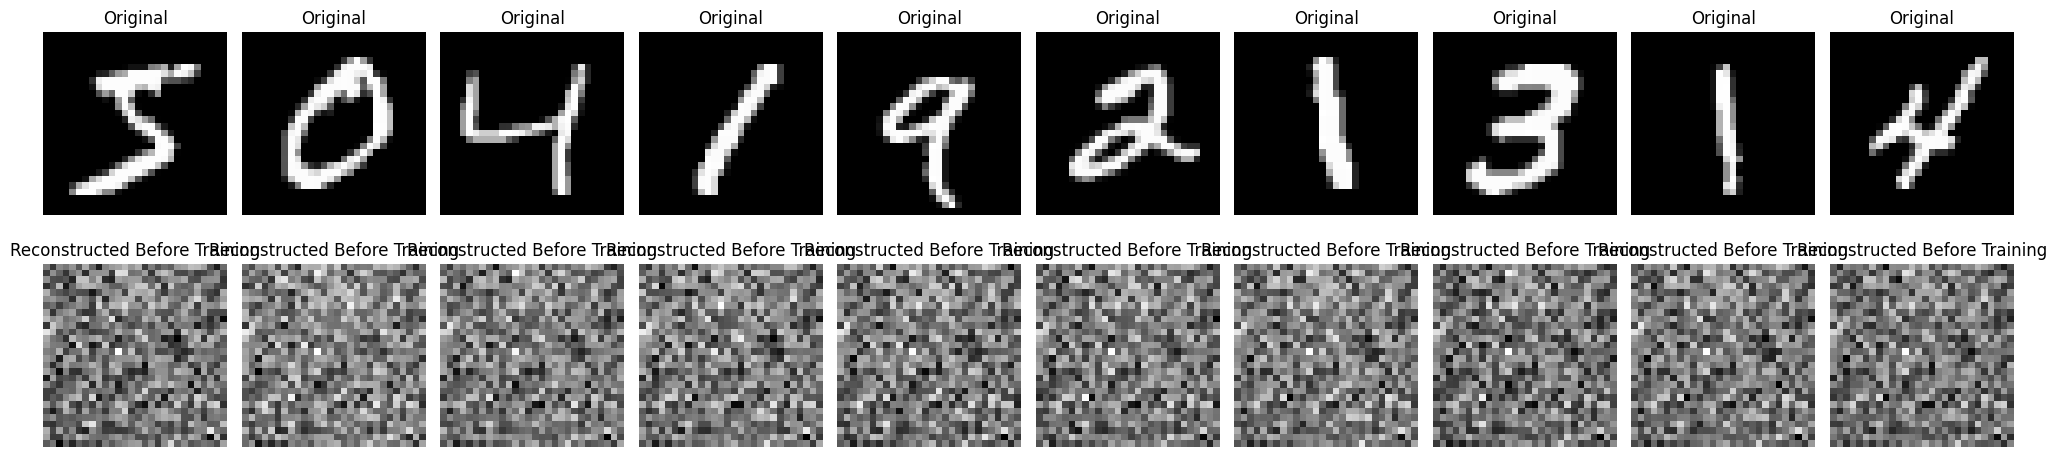

In [48]:
n_images = 10
originals = x_train[:n_images]
reconstructions_before = rbm.reconstruct(originals)

fig, axes = plt.subplots(2, n_images, figsize=(20, 5))
for i in range(n_images):
    axes[0, i].imshow(originals[i].reshape(28, 28), cmap='gray')
    axes[0, i].set_title('Original')
    axes[0, i].axis('off')

    axes[1, i].imshow(reconstructions_before[i].reshape(28, 28), cmap='gray')
    axes[1, i].set_title('Reconstructed Before Training')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

In [49]:
costs = rbm.train(x_train, learning_rate, k, epochs, batch_size)

Epoch: 1, Reconstruction Error: 20.191104414724144
Epoch: 2, Reconstruction Error: 17.737127011624032
Epoch: 3, Reconstruction Error: 16.5127604230873
Epoch: 4, Reconstruction Error: 15.724215310250912
Epoch: 5, Reconstruction Error: 15.158289256861437
Epoch: 6, Reconstruction Error: 14.761700194012498
Epoch: 7, Reconstruction Error: 14.395215857153177
Epoch: 8, Reconstruction Error: 14.118452211799728
Epoch: 9, Reconstruction Error: 13.858017855992784
Epoch: 10, Reconstruction Error: 13.702033010479921
Epoch: 11, Reconstruction Error: 13.521698823240603
Epoch: 12, Reconstruction Error: 13.413637942342193
Epoch: 13, Reconstruction Error: 13.302137153922938
Epoch: 14, Reconstruction Error: 13.210923350055808
Epoch: 15, Reconstruction Error: 13.108091288396478
Epoch: 16, Reconstruction Error: 13.03917202722906
Epoch: 17, Reconstruction Error: 12.988207437807377
Epoch: 18, Reconstruction Error: 12.920438013949688
Epoch: 19, Reconstruction Error: 12.84660253069947
Epoch: 20, Reconstruction

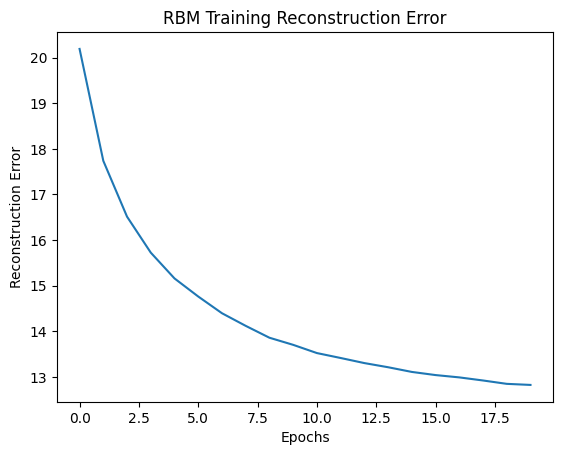

In [50]:
plt.plot(costs)
plt.xlabel('Epochs')
plt.ylabel('Reconstruction Error')
plt.title('RBM Training Reconstruction Error')
plt.show()

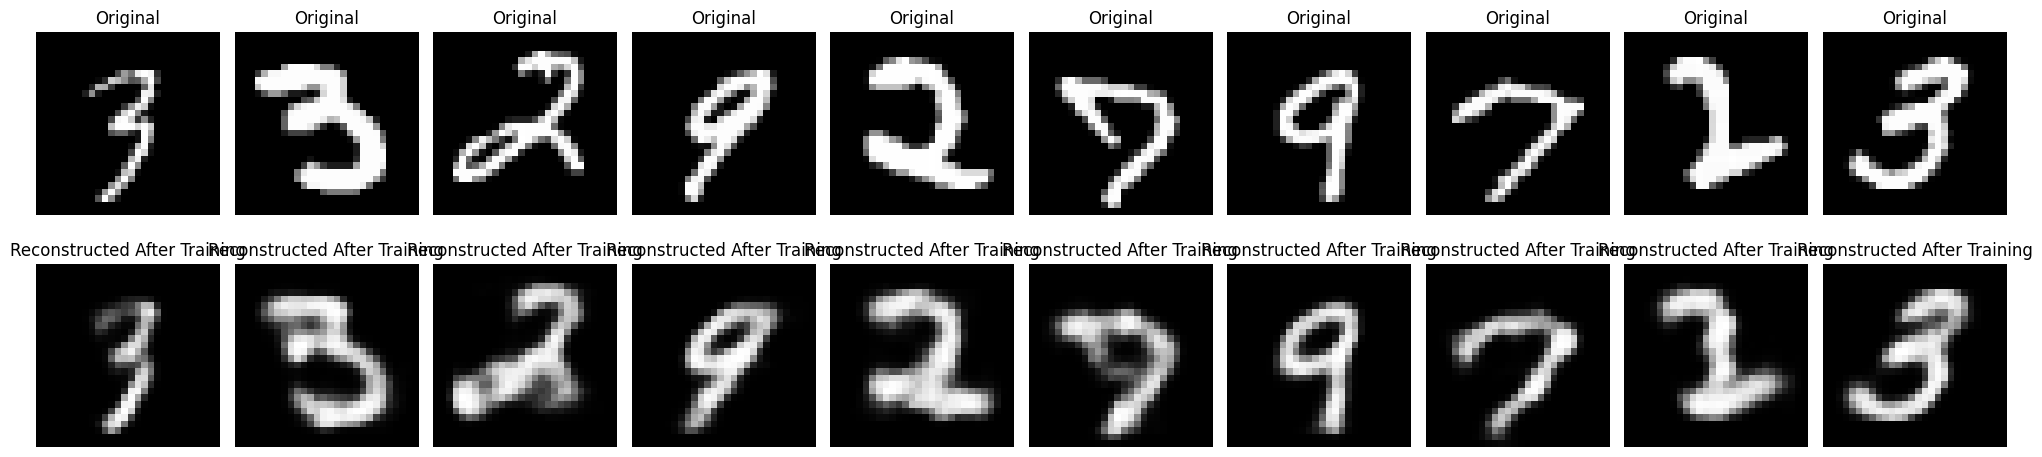

In [51]:
reconstructions_after = rbm.reconstruct(originals)
fig, axes = plt.subplots(2, n_images, figsize=(20, 5))
for i in range(n_images):
    axes[0, i].imshow(originals[i].reshape(28, 28), cmap='gray')
    axes[0, i].set_title('Original')
    axes[0, i].axis('off')

    axes[1, i].imshow(reconstructions_after[i].reshape(28, 28), cmap='gray')
    axes[1, i].set_title('Reconstructed After Training')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

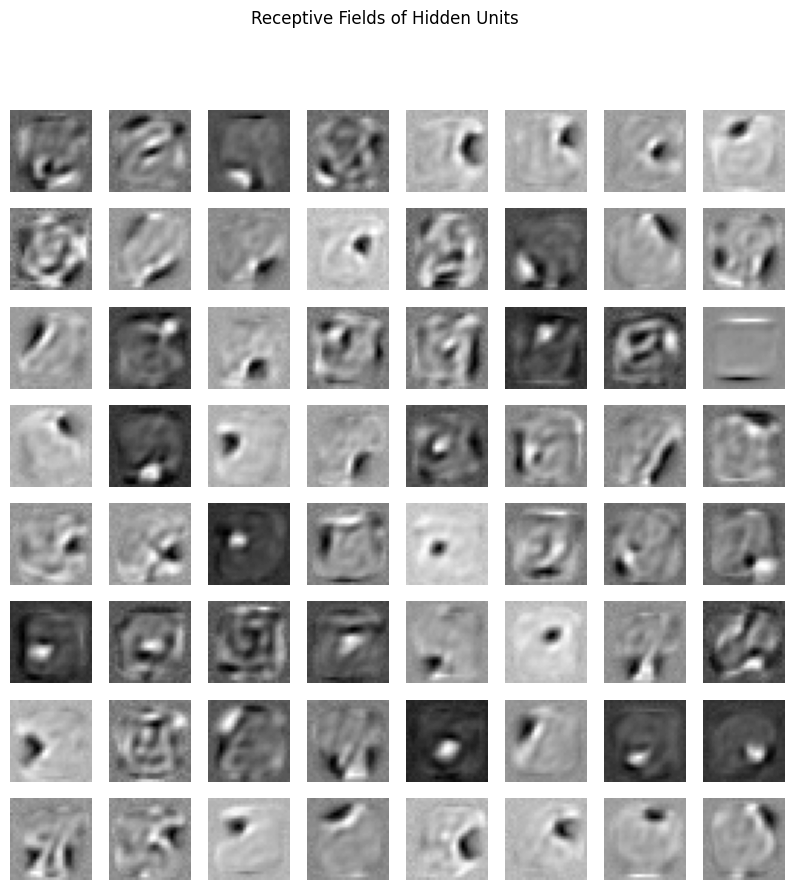

In [52]:
rbm.plot_receptive_fields((28, 28))

# ***Stripe Data***

In [53]:
stripe_data = np.array([
    [1, 0, 1, 0],
    [1, 0, 1, 0],
    [0, 1, 0, 1],
    [0, 1, 0, 1]
])

stripe_data = stripe_data.reshape(-1, 16)

In [54]:
num_visible = 16  #4x4
num_hidden = 4
learning_rate = 0.1
k = 1
epochs = 500
batch_size = 1

In [55]:
rbm_stripe = RBM(num_visible=num_visible, num_hidden=num_hidden)

In [56]:
initial_free_energy = rbm_stripe.free_energy(stripe_data)
initial_pseudo_likelihood = rbm_stripe.pseudo_likelihood(stripe_data)

In [57]:
costs_stripe = rbm_stripe.train(stripe_data, learning_rate, k, epochs, batch_size)

Epoch: 1, Reconstruction Error: 3.6603286256267342
Epoch: 2, Reconstruction Error: 3.2085520089053032
Epoch: 3, Reconstruction Error: 2.5941561010826426
Epoch: 4, Reconstruction Error: 2.208728329782871
Epoch: 5, Reconstruction Error: 1.8977303572588862
Epoch: 6, Reconstruction Error: 1.6501217002040764
Epoch: 7, Reconstruction Error: 1.4325244607328924
Epoch: 8, Reconstruction Error: 1.1025290201418856
Epoch: 9, Reconstruction Error: 1.0640098676418746
Epoch: 10, Reconstruction Error: 0.9082333935291196
Epoch: 11, Reconstruction Error: 0.836828790357267
Epoch: 12, Reconstruction Error: 0.5765220804603721
Epoch: 13, Reconstruction Error: 0.5055731847644113
Epoch: 14, Reconstruction Error: 0.4665542176824078
Epoch: 15, Reconstruction Error: 0.3944873379908108
Epoch: 16, Reconstruction Error: 0.35207695954627327
Epoch: 17, Reconstruction Error: 0.3375245085609949
Epoch: 18, Reconstruction Error: 0.24454052919222014
Epoch: 19, Reconstruction Error: 0.24454052919222014
Epoch: 20, Reconstru

In [58]:
final_free_energy = rbm_stripe.free_energy(stripe_data)
final_pseudo_likelihood = rbm_stripe.pseudo_likelihood(stripe_data)

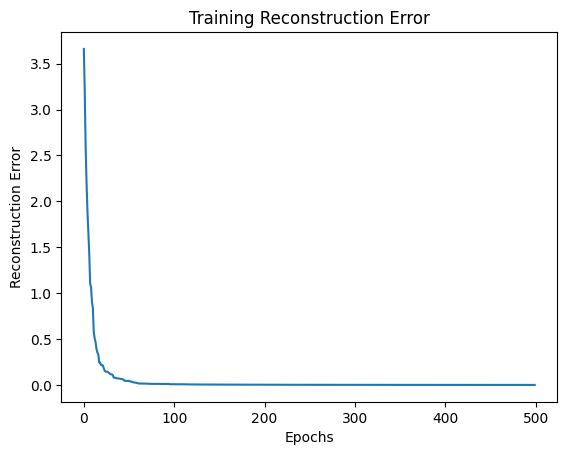

In [59]:
plt.plot(costs_stripe)
plt.xlabel('Epochs')
plt.ylabel('Reconstruction Error')
plt.title('Training Reconstruction Error')
plt.show()

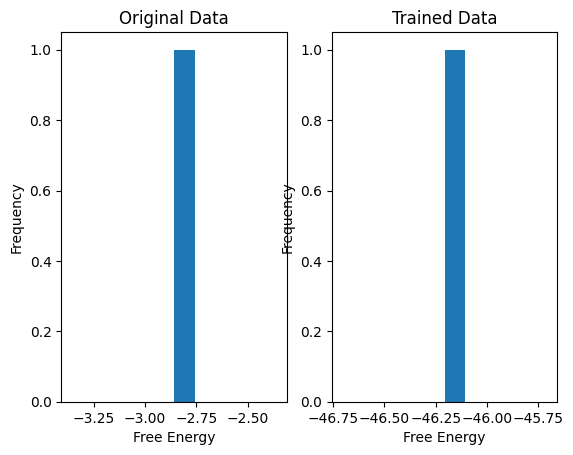

In [60]:
plt.subplot(1, 2, 1)
plt.hist(initial_free_energy)
plt.xlabel('Free Energy')
plt.ylabel('Frequency')
plt.title('Original Data')

plt.subplot(1, 2, 2)
plt.hist(final_free_energy)
plt.xlabel('Free Energy')
plt.ylabel('Frequency')
plt.title('Trained Data')
plt.show()


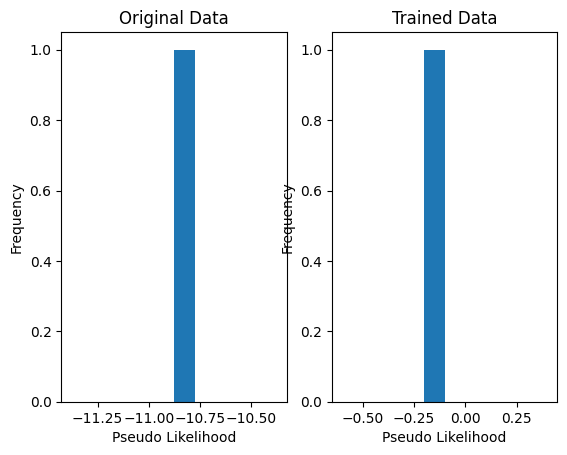

In [61]:
plt.subplot(1, 2, 1)
plt.hist(initial_pseudo_likelihood)
plt.xlabel('Pseudo Likelihood')
plt.ylabel('Frequency')
plt.title('Original Data')


plt.subplot(1, 2, 2)
plt.hist(final_pseudo_likelihood)
plt.xlabel('Pseudo Likelihood')
plt.ylabel('Frequency')
plt.title('Trained Data')
plt.show()